In [1]:
import tensorflow as tf
from utils import actomyosin_data, plot
from model.autoencoder import AE, VAE, CVAE
from train_utils.autoencoder import AETrain, VAETrain, CVAETrain
import time
import argparse

import numpy as np
import tifffile
import os
from skimage.transform import resize
from skimage.io import imsave, imread



2024-03-20 22:01:10.671120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 22:01:10.671228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 22:01:10.672421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 22:01:10.682459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = '/net/projects/CLS/actomyosin_dynamics/data/LifeAct-NMY2-GFP_NMY2_wt_all_ps_64/NMY2_wt'
patch_size = 28

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]

num_of_samples = len(filenames)

train_images = np.zeros([num_of_samples, patch_size, patch_size])
train_labels= np.zeros([num_of_samples])

for filename_ind in range(num_of_samples):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))
    small_train_img = resize(train_img, (28, 28))
    small_train_img = small_train_img/((small_train_img.max()))
    train_images[filename_ind,:,:] = small_train_img
    train_labels[filename_ind] = int(filename_ind/200)


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')



In [15]:
TRAIN_BUF = 5000
batch_size = 1000
BATCH_SIZE = batch_size

train_dataset_image = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
train_dataset_label = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.zip((train_dataset_image, train_dataset_label)).shuffle(TRAIN_BUF)

In [16]:
train_labels

array([ 0.,  0.,  0., ..., 68., 68., 68.])

In [25]:
ae_type = 'AE'
batch_size = 1000
latent_dim = 2
num_epochs = 200
learn_rate = 0.001

model = AE(latent_dim, net_type='simple')

In [26]:
optimizer = tf.keras.optimizers.Adam(learn_rate)

for epoch in range(1, num_epochs + 1):
    t = time.time()
    last_loss = 0
    for train_x, _ in train_dataset:
        gradients, loss = AETrain.compute_gradients(model, train_x)
        AETrain.apply_gradients(optimizer, gradients, model.trainable_variables)
        last_loss = loss
    if epoch % 10 == 0:
        print('Epoch {}, Loss: {}, Remaining Time at This Epoch: {:.2f}'.format(
            epoch, last_loss, time.time() - t
        ))



Epoch 10, Loss: 0.5495651960372925, Remaining Time at This Epoch: 0.33
Epoch 20, Loss: 0.5354586839675903, Remaining Time at This Epoch: 0.32
Epoch 30, Loss: 0.5365182757377625, Remaining Time at This Epoch: 0.31
Epoch 40, Loss: 0.5340463519096375, Remaining Time at This Epoch: 0.32
Epoch 50, Loss: 0.5327256321907043, Remaining Time at This Epoch: 0.34
Epoch 60, Loss: 0.5335332751274109, Remaining Time at This Epoch: 0.33
Epoch 70, Loss: 0.5321710109710693, Remaining Time at This Epoch: 0.33
Epoch 80, Loss: 0.5332071185112, Remaining Time at This Epoch: 0.34
Epoch 90, Loss: 0.5306727290153503, Remaining Time at This Epoch: 0.34
Epoch 100, Loss: 0.5320369005203247, Remaining Time at This Epoch: 0.34
Epoch 110, Loss: 0.5304539799690247, Remaining Time at This Epoch: 0.39
Epoch 120, Loss: 0.5324103236198425, Remaining Time at This Epoch: 0.34
Epoch 130, Loss: 0.531345784664154, Remaining Time at This Epoch: 0.36
Epoch 140, Loss: 0.5306697487831116, Remaining Time at This Epoch: 0.35
Epoch

2024-03-20 22:50:43.710613: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99MiB (rounded to 3136000)requested by op Tile
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-20 22:50:43.711901: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-20 22:50:43.711982: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 78, Chunks in use: 75. 19.5KiB allocated for chunks. 18.8KiB in use in bin. 7.1KiB client-requested in use in bin.
2024-03-20 22:50:43.712009: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 36, Chunks in use: 36. 19.5KiB allocated for chunks. 19.5KiB in use in bin. 18.0KiB client-requested in use in bin.
2024-03-20 22:50:43.712030: 

ResourceExhaustedError: {{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1000,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile] name: 

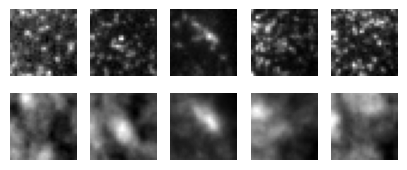

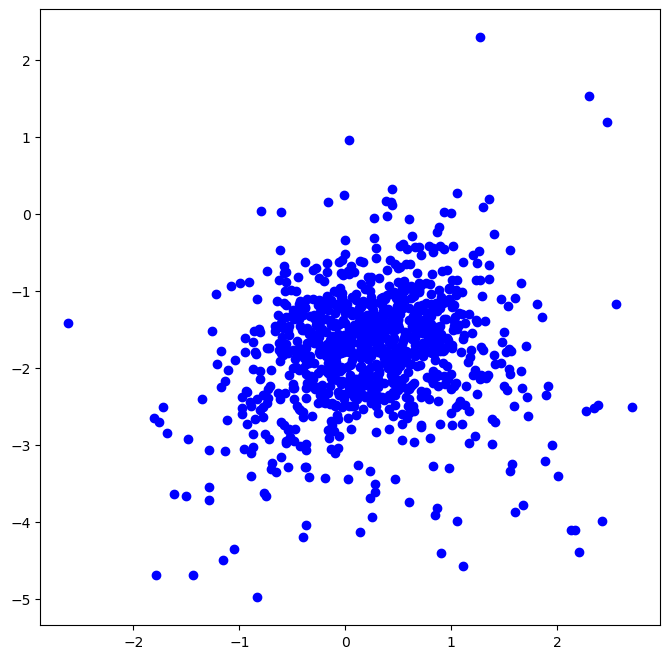

In [24]:
from utils import plot
plot.plot_AE(model, train_dataset)

In [ ]:

colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
cs = [colors[y] for y in labels]